In [1]:
import pandas as pd
import numpy as np
from scipy.stats import binom, poisson, geom
import math
import matplotlib.pyplot as plt
import timeit
from scipy.stats import linregress
from scipy.special import factorial

class Network ( object ) :
    def __init__ ( self , num_nodes ) :
        self . adj = { i :set () for i in range ( num_nodes ) }

    def add_edge ( self , i , j ) :
        self . adj [ i ]. add ( j )
        self . adj [ j ]. add ( i )

    def neighbors ( self , i ) :
        return self . adj [ i ]

    def edge_list ( self ) :    
        return [( i , j ) for i in self . adj for j in self . adj [ i ] if i < j ]

In [2]:
def generate_edge_list (k):
#n is the number of nodes, k is the degree distribution ( a list where k[i] is)
#the degree of node i)
    n = len ( k )
    S = np.array ([ i for i in range ( n ) for _ in range ( k [ i ]) ])
    S = np.random.permutation ( S )
    if len ( S ) % 2:
        S = S [: -1]
    S = S . reshape ( -1 , 2)
    return S

In [3]:
def generate_H():
    n = 150000
    s = 25000
    k_max = 1000

    #Homogenous network - mean = 6
    k = np.zeros (n, dtype=int)
    for i in range(n):
        k[i] = np.random.geometric(1/7)-1

    k = np.clip(k, None, k_max)

    S = generate_edge_list(k)
    H = Network(n)
    for i, j in S:
            H.add_edge(i, j)
    return H

def generate_I(student_mean, non_student_mean, interconnections):
    n = 150000
    s = 25000
    k_max = 1000
    p = 1/(student_mean+1)
    k_students = np.random.geometric(p, size=s)
    k_students = k_students - 1
    k_students = np.clip(k_students, None, k_max)

    k_non_students = np.random.geometric(1/(non_student_mean+1), size=n - s)
    k_non_students = k_non_students -1
    k_non_students = np.clip(k_non_students, None, k_max)

    S_edges = generate_edge_list(k_students)
    N_edges = generate_edge_list(k_non_students)
    N_edges_shifted = [(i + s, j + s) for i, j in N_edges]
    
    num_edges_per_student = np.random.poisson(interconnections, size=s)
    student_nodes = np.repeat(np.arange(s), num_edges_per_student)
    num_inter = len(student_nodes)

    targets = np.random.randint(s, n, size=num_inter)
    inter_edges = np.stack([student_nodes, targets], axis=1)

    all_edges = np.vstack((S_edges, N_edges_shifted, inter_edges))
        
    I = Network(n)
    for i, j in all_edges:
        I.add_edge(i, j)   

    return I

In [4]:
def simulation_setup (n, starting_infected):
    #pick starting fraction in I
    p_0 = starting_infected * n

    #randomly pick starting nodes
    I_0 = set()
    for i in range(int(p_0)):
        k = np.random.randint(0, n)
        while k in I_0:
            k = np.random.randint(0, n)
        I_0.add(k)

    R_0 = set()

    S_0 = set()
    for i in range(n):
        if i not in I_0:
            S_0.add(i)

    return S_0, I_0, R_0

In [5]:
def run_week(S, I, R, G, λ):
    R_copy = R.copy()
    S_copy = S.copy()
    I_copy = I.copy()


    for i in I:
        for j in G.neighbors(i):
            if j in S_copy:
                if np.random.uniform(0, 1) < λ:
                    S_copy.remove(j)
                    I_copy.add(j)
        I_copy.remove(i)
        R_copy.add(i)

    S = S_copy
    I = I_copy
    R = R_copy


    return S, I, R

In [6]:
def run_simulation (G, I_0, R_0, S_0, λ, weeks):
    Susceptible = []
    Infectious = []
    Recovered = []

    Susceptible.append(len(S_0))
    Infectious.append(len(I_0))
    Recovered.append(len(R_0))

    for i in range(weeks):
        S_0, I_0, R_0 = run_week(S_0, I_0, R_0, G, λ)
        Susceptible.append(len(S_0))
        Infectious.append(len(I_0))
        Recovered.append(len(R_0))

    return Recovered

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

n = 150000
λ = 0.05
μ = 0.05
s = 25000
interconnections = np.linspace(0, 20, 21)
weeks = 100
student_means = np.linspace(0, 40, 21)

# Create a 2D array: rows = interconnections, cols = student means
outbreak_matrix = np.zeros((len(interconnections), len(student_means)))

for i_idx, i in enumerate(interconnections):
    print(i)
    for m_idx, m in enumerate(student_means):
        I = generate_I(m, 4, i)
        S_0, I_0, R_0 = simulation_setup(n, 0.01)
        Recovered = run_simulation(I, I_0, R_0, S_0, λ, weeks)
        outbreak_matrix[i_idx, m_idx] = Recovered[-1]

0.0
1.0
2.0
3.0
4.0
5.0
6.0
7.0
8.0
9.0
10.0
11.0
12.0
13.0
14.0
15.0
16.0
17.0
18.0
19.0
20.0


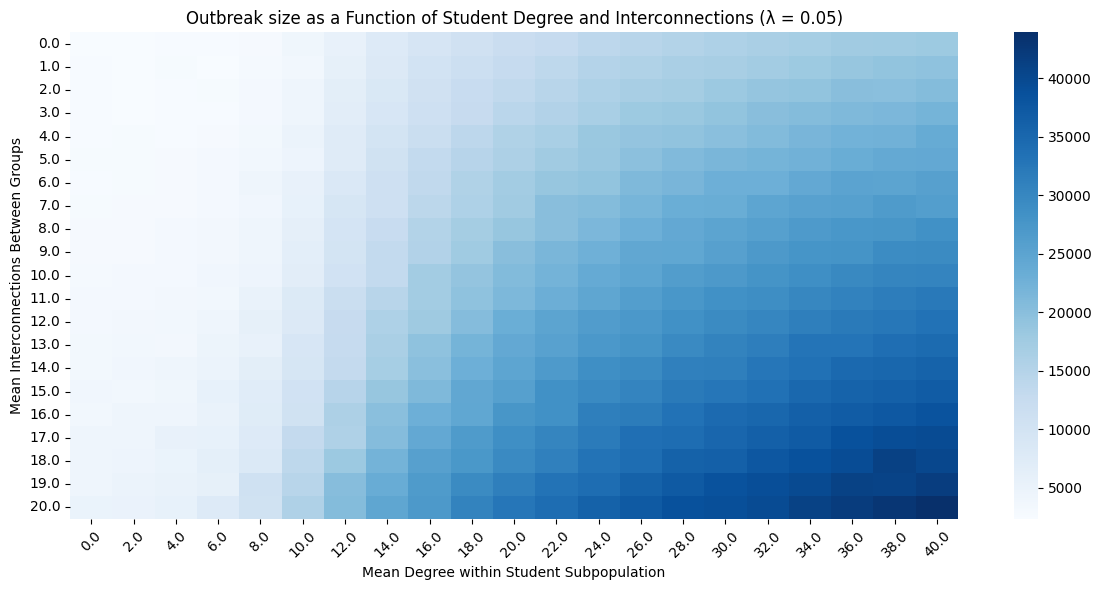

In [ ]:
plt.figure(figsize=(12, 6))
sns.heatmap(outbreak_matrix, 
            xticklabels=np.round(student_means, 1), 
            yticklabels=interconnections, 
            cmap="Blues", 
            annot=False)

plt.title("Outbreak size as a Function of Student Degree and Interconnections (λ = 0.05)")
plt.xlabel("Mean Degree within Student Subpopulation")
plt.ylabel("Mean Interconnections Between Groups")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [8]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

n = 150000
λ = 0.1
μ = 0.05
s = 25000
interconnections = np.linspace(0, 20, 21)
weeks = 100
student_means = np.linspace(0, 40, 21)

# Create a 2D array: rows = interconnections, cols = student means
outbreak_matrix = np.zeros((len(interconnections), len(student_means)))

for i_idx, i in enumerate(interconnections):
    print(i)
    for m_idx, m in enumerate(student_means):
        I = generate_I(m, 4, i)
        S_0, I_0, R_0 = simulation_setup(n, 0.01)
        Recovered = run_simulation(I, I_0, R_0, S_0, λ, weeks)
        outbreak_matrix[i_idx, m_idx] = Recovered[-1]

0.0
1.0
2.0
3.0
4.0
5.0
6.0
7.0
8.0
9.0
10.0
11.0
12.0
13.0
14.0
15.0
16.0
17.0
18.0
19.0
20.0


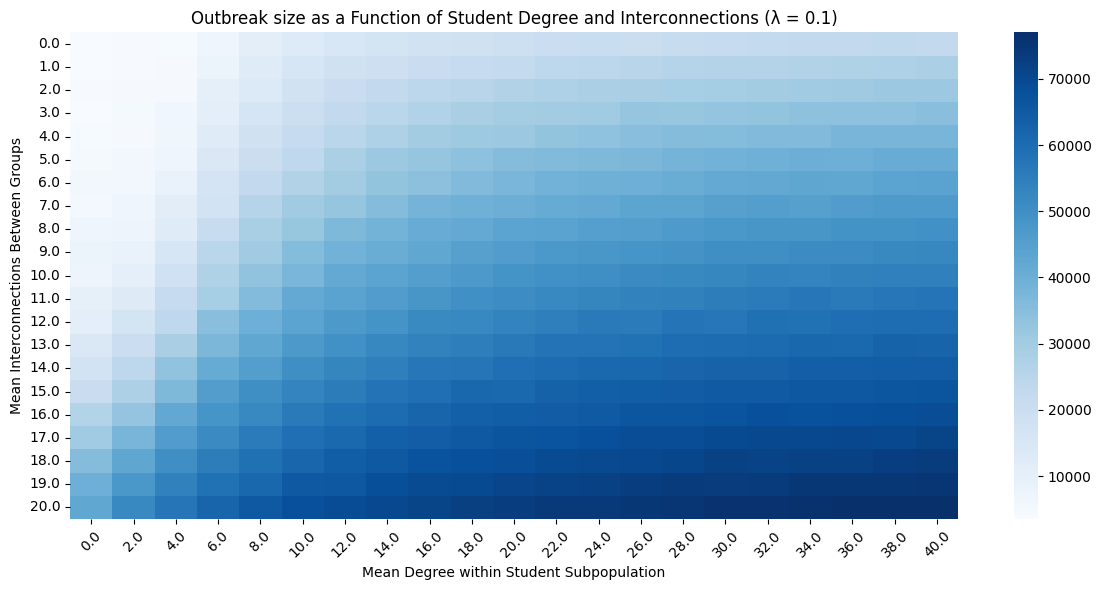

In [9]:
plt.figure(figsize=(12, 6))
sns.heatmap(outbreak_matrix, 
            xticklabels=np.round(student_means, 1), 
            yticklabels=interconnections, 
            cmap="Blues", 
            annot=False)

plt.title("Outbreak size as a Function of Student Degree and Interconnections (λ = 0.1)")
plt.xlabel("Mean Degree within Student Subpopulation")
plt.ylabel("Mean Interconnections Between Groups")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

n = 150000
λ = 0.2
μ = 0.05
s = 25000
interconnections = np.linspace(0, 20, 21)
weeks = 100
student_means = np.linspace(0, 40, 21)

# Create a 2D array: rows = interconnections, cols = student means
outbreak_matrix = np.zeros((len(interconnections), len(student_means)))

for i_idx, i in enumerate(interconnections):
    print(i)
    for m_idx, m in enumerate(student_means):
        I = generate_I(m, 4, i)
        S_0, I_0, R_0 = simulation_setup(n, 0.01)
        Recovered = run_simulation(I, I_0, R_0, S_0, λ, weeks)
        outbreak_matrix[i_idx, m_idx] = Recovered[-1]

0.0


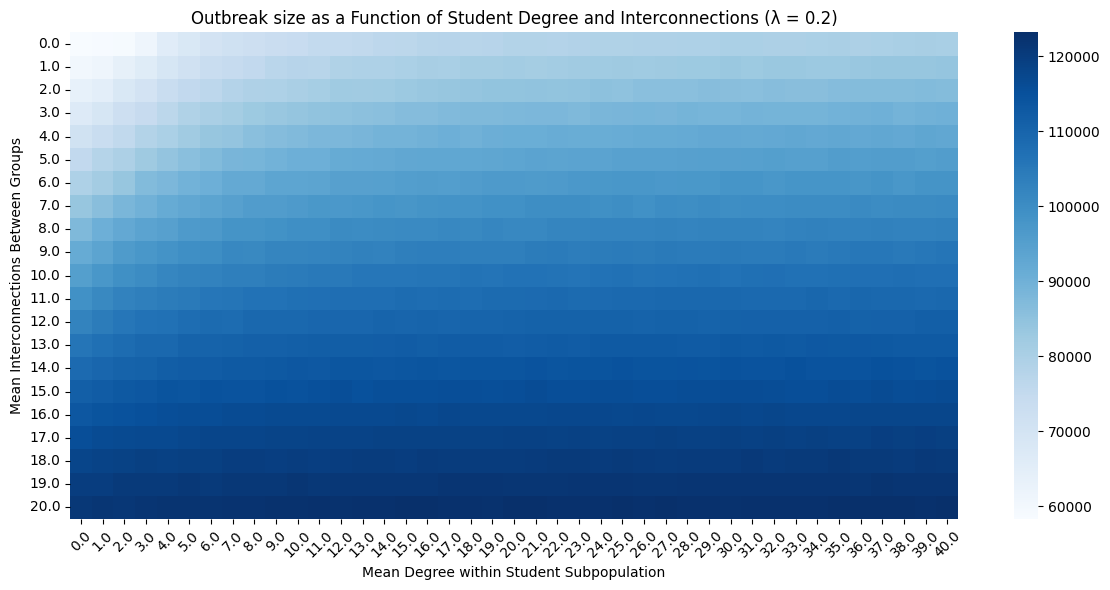

In [ ]:
plt.figure(figsize=(12, 6))
sns.heatmap(outbreak_matrix, 
            xticklabels=np.round(student_means, 1), 
            yticklabels=interconnections, 
            cmap="Blues", 
            annot=False)

plt.title("Outbreak size as a Function of Student Degree and Interconnections (λ = 0.2)")
plt.xlabel("Mean Degree within Student Subpopulation")
plt.ylabel("Mean Interconnections Between Groups")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()